# Introduction

Fortunately, with libraries such as Scikit-Learn, it’s now easy to build and use almost any machine learning algorithm. But it’s helpful to have an idea of how a machine learning model works under the hood. This lets us diagnose the model when it’s underperforming or explain how it makes decisions, which is crucial if we want to convince others to trust our models.
In this assignment, we’ll look at how to build and use the Decision Tree and the Random Forest in Python. We’ll start by understanding how a single decision tree makes classifications on a simple problem. Then, we’ll work our way to using a random forest on a real-world data science problem.

# Dataset

The dataset we will use in this assignment is the Sonar dataset.

This is a dataset that describes sonar chirp returns bouncing off different surfaces. The 60 predictors are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders. There are 208 observations.

It is a well-understood dataset. All of the variables are continuous and generally in the range of 0 to 1. The output variable is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.

By predicting the class with the most observations in the dataset (M or mines) the Zero Rule Algorithm can achieve an accuracy of 53%.

You can learn more about this dataset at the UCI Machine Learning repository.
https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

Download the dataset for free and place it in the "data" folder in your working directory with the filename sonar.all-data.csv.

# Import section

In [1]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

np.random.seed(2020)
random.seed(2020)

# Preprocess data

Read data and convert targets to integers 1 and 0.

In [2]:
PATH = 'data/'
df = pd.read_csv(PATH+'sonar-all-data.csv', header=None)
df.columns = [f'feat_{col}' if col!=60 else 'target' for col in df.columns]
df['target'] = df['target'].map({'M': 1, 'R': 0})
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


# Split data (train and test)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=2020)

# Cost functions

In this section you should implement two cost functions. Any of these can be used in the model.

## Gini index

In [4]:
def gini_index(x):
    """ Calculate Gini Index for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Gini index
    """    
    if len(x) == 0:
        return 0.0
    p = np.bincount(x) / len(x)
    return 1 - np.sum(p*p)

In [5]:
target = df['target'].values
gini_index(target)

0.4977348372781065

In [6]:
def gini_gain(parent_node, splits):
    """ Calculate Gini Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Gini gain
    """       
    splits_gini = np.sum([gini_index(split)*(len(split)/len(parent_node)) for split in splits])
    return gini_index(parent_node) - splits_gini

In [7]:
splits = [np.random.choice(df['target'].values, 100), np.random.choice(df['target'].values, 108)]
gini_gain(target, splits)

-0.0003705758273065962

## Entropy

In [8]:
def entropy(x):
    """ Calculate Entropy for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Entropy
    """
    if len(x) == 0:
        return 0.0
    p = np.clip(np.bincount(x) / len(x), 1e-15, 1.)
    return -np.sum(p * np.log(p))

In [9]:
def information_gain(parent_node, splits):
    """ Calculate Information Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Information Gain
    """     
    splits_entropy = np.sum([entropy(split)*(len(split)/len(parent_node)) for split in splits])
    return entropy(parent_node) - splits_entropy

# Split function

Implement split functions

In [10]:
def split(X, y, value):
    """ Split y-values in order to calculate gain later
    Args:
        X: 1-dimensional numpy-array of data predictor with shape (N,)
        y: 1-dimensional numpy-array of targets with shape (N,)
        value (float): the value by which the X should be splitted
    Returns:
        Two 1-dimensional numpy-arrays with targets related to splits
    """      
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]


def split_dataset(X, y, column, value):
    """ Split dataset by a particular column and value
    Args:
        X: 2-dimensional numpy-array (N, num_feats). N-number of samples
        y: 1-dimensional numpy-array of targets with shape (N,)  
        column (int): the column by which the X should be splitted
        value (float): the value by which the column should be splitted
    Returns:
        Two 2-dimensional numpy-arrays with data and two 1-dimensional numpy-arrays with targets related to splits
        left_X, right_X, left_y, right_y
    """       
    left_mask = X[:, column] < value
    right_mask = X[:, column] >= value
    left_y, right_y = y[left_mask], y[right_mask]
    left_X, right_X = X[left_mask], X[right_mask]
    return left_X, right_X, left_y, right_y

# Decision tree

In [11]:
class Tree(object):
    """A decision tree classifier.

    Args:
        criterion : {"gini_gain", "information_gain"}
    """
    def __init__(self, criterion=None):
        self.impurity = None
        self.threshold = None
        self.column_index = None
        self.outcome_probs = None
        self.criterion = criterion
        self.left_child = None
        self.right_child = None

    @property
    def is_terminal(self):
        """ Define is it terminal node
        """          
        return not bool(self.left_child and self.right_child)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""

        # Sample random subset of features
        subset = random.sample(list(range(0, X.shape[1])), n_features)
        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                gain = self.criterion(y, splits)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain

    def fit(self, X, y, n_features=None, max_depth=None):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
            n_features (int): The number of features when fit is performed (default: all features)
            max_depth (int): The maximum depth of the tree. If None, then nodes are expanded until
                             all leaves are pure.
        """        
        try:
            # Exit from recursion using assert syntax
            if max_depth is not None:
                assert max_depth > 0
                max_depth -= 1

            if n_features is None:
                n_features = X.shape[1]

            column, value, gain = self._find_best_split(X, y, n_features)
            assert gain is not None

            self.column_index = column
            self.threshold = value
            self.impurity = gain

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

            # Grow left and right child
            self.left_child = Tree(self.criterion)
            self.left_child.fit(
                left_X, left_target, n_features, max_depth
            )

            self.right_child = Tree(self.criterion)
            self.right_child.fit(
                right_X, right_target, n_features, max_depth
            )
        except AssertionError:
            self.outcome_probs = np.around(np.sum(y) / y.shape[0])


    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome_probs

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        """  
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

Fit two models with "max_depth=3" and "max_depth=None" hyperparameters. Explain the results.

In [12]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


In [13]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


In [14]:
model = Tree(criterion=information_gain)
model.fit(X_train.values, y_train.values, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.7380952380952381


# Random forest

In [15]:
class RandomForestClassifier(object):
    """
    A random forest classifier.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        n_features : int, default=None
            The number of features to consider when looking for the best split.
            If None, then `n_features=sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
    """

    def __init__(self, n_estimators=10, max_depth=None, n_features=None, criterion="entropy", bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        
        if criterion == "entropy":
            self.criterion = information_gain
        elif criterion == "gini":
            self.criterion = gini_gain
        else:
            raise ValueError(f"Unknown criterion '{criterion}'")
            
        self.trees = [Tree(criterion=self.criterion) for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return np.random.randint(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """         
        if self.n_features is None:
            self.n_features = int(np.sqrt(X.shape[1]))
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            tree.fit(
                X,
                y,
                n_features=self.n_features,
                max_depth=self.max_depth,
            )
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """            
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators
                predictions[i] = round(row_pred)
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

Fit two models with "n_estimators=10" and "n_estimators=100" hyperparameters. Explain the results.

In [16]:
model = RandomForestClassifier(n_estimators=10, max_depth=None, n_features=None, criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.7380952380952381


In [17]:
model = RandomForestClassifier(n_estimators=100, max_depth=None, n_features=None, criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.8809523809523809


Now it's your turn to explore the various parameters of sklearn [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and their influence on model quality.

# Homework part 1. RandomForestClassifier

_Note_: Consider **accuracy** as main metric of model performance on this dataset.

In [18]:
from sklearn.ensemble import RandomForestClassifier

**Task 1 (0.5 points)** Split the dataset into train, test and validation parts (0.6 / 0.2 / 0.2). First two will be used for model hyperparameter tuning whereas the best model quality should be evaluated on validation part.

In [19]:
from sklearn.model_selection import train_test_split

X_full, X_valid, y_full, y_valid = train_test_split(df.drop(columns='target'), df['target'], 
                                                    test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.25, random_state=42)
print(f'Train set size: {X_train.shape[0]}, test set size: {X_test.shape[0]}, validation set size: {X_valid.shape[0]}')

Train set size: 124, test set size: 42, validation set size: 42


**Task 2 (2 points)**. Apply '_greedy_' hyperparameter tuning of RandomForestClassifier model. '_Greedy_' way means the following general approach. At first we tune one model parameter whereas others are fixed with default values. Then we move on to tune the second parameter whereas others are fixed default values and first has the best values from previous step. After it we tune the third parameter with best fixed values for previous two and default values for the rest. Repeat until we go through all the parameters, then repeat this cycle if you are seeing a clear increase in the test metric. <br>

Although this approach has a lot of disadvantages (you may think which ones), sometimes that is the only way to tune model typerparams due to big training time **if you understand how the model parameters are interrelated and the tuning order takes those dependencies into account.**<br>

Here is one of the possible options for RandomForestClassifier:
- Choose a decent value for number of trees using '_elbow_' rule. You may plot the dependence of accuracy on trees_num and pick up the number after which the error decreases not **as much as before**. 
- Pick up the best split criterion ('gini' / 'entropy') and then tune _max_depth_, _min_samples_split_, _min_samples_leaf_.
- Increase number of trees with best found parameters so far.
- Repeat this excersice starting from picking the best split criterion while other params are fixed with best values from previous steps **if you observe a significant test metric improvement**. Otherwise just stop and measure your best model result on validation set.

In [20]:
# defining search parameters

n_trees = np.linspace(1, 200, 10, dtype=int)
c_split = ['gini', 'entropy']
max_depths = np.linspace(1, 20, 20)
min_samples_splits = range(2, 21)
min_sample_leaf = range(1, 21)

In [21]:
# searching for optimal number of trees

scores = []
for n in n_trees:
    clf = RandomForestClassifier(n_estimators=n, random_state=42)
    clf.fit(X_train, y_train)
    accuracy_score = clf.score(X_test, y_test)
    scores.append(accuracy_score)
print(f'Maximum accuracy {max(scores):.4f} reached at {n_trees[scores.index(max(scores))]} number of estimators')    

Maximum accuracy 0.8333 reached at 23 number of estimators


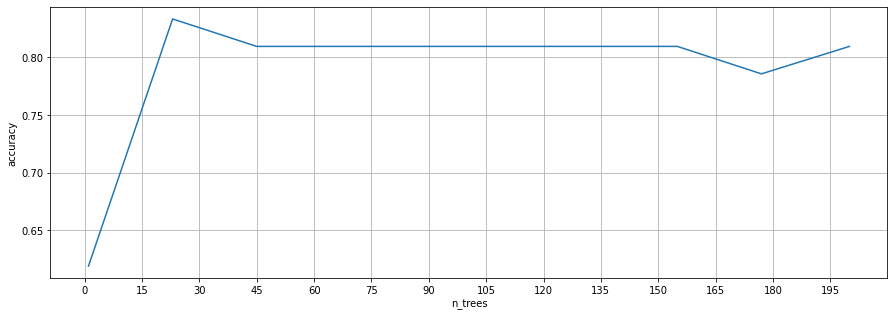

Optimal number of trees according to elbow method is approximately 20


In [22]:
# plotting 'elbow' graph

plt.figure(figsize=(15,5))
plt.plot(n_trees, scores)
plt.xticks(np.arange(0, 200, step=15))
plt.grid()
plt.xlabel('n_trees')
plt.ylabel('accuracy')
plt.show()
print('Optimal number of trees according to elbow method is approximately 20')

In [23]:
# searching for split criterion

scores = []
for i in c_split:
    clf = RandomForestClassifier(n_estimators=20, criterion=i, random_state=42)
    clf.fit(X_train, y_train)
    accuracy_score = clf.score(X_test, y_test)
    scores.append(accuracy_score)
print(f'Maximum accuracy {max(scores):.4f} reached with {c_split[scores.index(max(scores))]} criterion')

Maximum accuracy 0.8095 reached with gini criterion


In [24]:
# searching for max_depth of the tree

scores = []
for i in max_depths:
    clf = RandomForestClassifier(n_estimators=20, criterion='gini', max_depth=i, random_state=42)
    clf.fit(X_train, y_train)
    accuracy_score = clf.score(X_test, y_test)
    scores.append(accuracy_score)
print(f'Maximum accuracy {max(scores):.4f} reached with max_depth value of {max_depths[scores.index(max(scores))]}')

Maximum accuracy 0.8095 reached with max_depth value of 7.0


In [25]:
# search for min_samples_split

scores = []
for i in min_samples_splits:
    clf = RandomForestClassifier(n_estimators=20, criterion='gini', max_depth=7, min_samples_split=i, random_state=42)
    clf.fit(X_train, y_train)
    accuracy_score = clf.score(X_test, y_test)
    scores.append(accuracy_score)
print(f'Maximum accuracy {max(scores):.4f} reached with min_samples_split value of {min_samples_splits[scores.index(max(scores))]}')

Maximum accuracy 0.8095 reached with min_samples_split value of 2


In [26]:
# search for min_samples_leaf

scores = []
for i in min_sample_leaf:
    clf = RandomForestClassifier(n_estimators=20, criterion='gini', max_depth=7, min_samples_split=2, min_samples_leaf=i, random_state=42)
    clf.fit(X_train, y_train)
    accuracy_score = clf.score(X_test, y_test)
    scores.append(accuracy_score)
print(f'Maximum accuracy {max(scores):.4f} reached with min_samples_leaf value of {min_sample_leaf[scores.index(max(scores))]}')

Maximum accuracy 0.8810 reached with min_samples_leaf value of 6


In [27]:
greedy_clf = RandomForestClassifier(n_estimators=20, criterion='gini', max_depth=7, min_samples_split=2, min_samples_leaf=6, random_state=42)
greedy_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=6, n_estimators=20,
                       random_state=42)

In [28]:
score = greedy_clf.score(X_valid, y_valid)
print(f'Accuracy score reached with greedy approach is {score:.4}')

Accuracy score reached with greedy approach is 0.8095


### Grid Search and Random Search

If you have enough computational power for model training in a reasonable amount of time more sophisticated approach of hyperparameter tuning would be either Grid Search or Random Search.<br>

In a nutshell Grid Search allows you to pass through all different combinations of given model parameters and their values and choose the best combination. Whereas Random Search would randomly choose values for given model parameters and evaluate them on test data untill it reaches the specified number of iterations.<br>

More information here [Gentle introduction to Grid and Random search](https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318) and here [Detailed Explanation with code examples](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/).

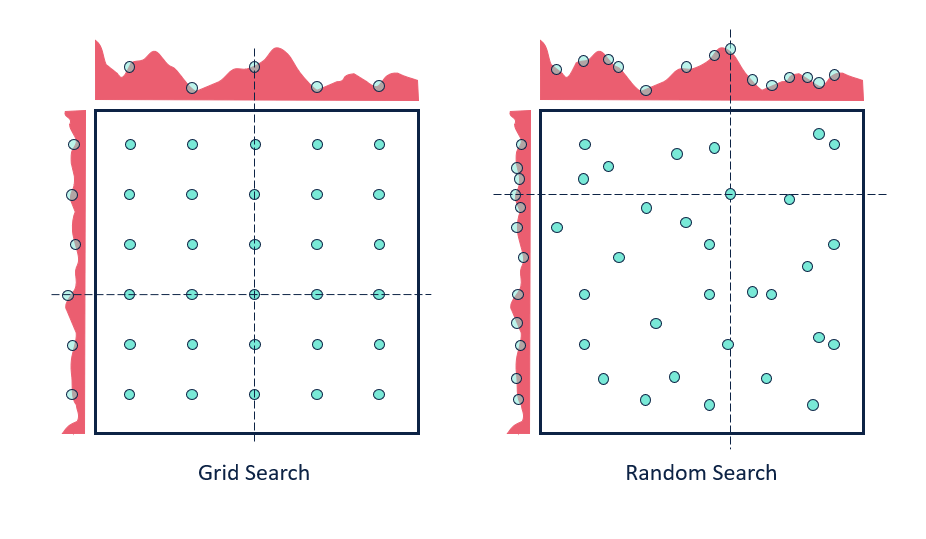

**Task 3 (1 point)**. Compare your previous results with [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) hyperparameter tuning. You may tune best hyperparameters for forest with several trees and then increase it while measure the quality on validation dataset.

In [29]:
from sklearn.model_selection import GridSearchCV

# considering previous experiments I made a search parameters cut-off to decrease computational time 

model_params = {'criterion': ['gini', 'entropy'], 
                 'max_depth': range(1, 11),
                 'min_samples_split': range(2, 11),
                 'min_samples_leaf': range(1, 11)
                 }


grid = GridSearchCV(RandomForestClassifier(n_estimators=23, random_state=42),
                    param_grid = model_params,
                    scoring='accuracy',
                    n_jobs=2,
                    verbose=1
                   )

# cv fitting on train+test set 

grid.fit(X_full, y_full)
grid.best_params_

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits


{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [30]:
grid_score = grid.score(X_valid, y_valid)
print(f'Accuracy score reached with GridSearchCv approach is {grid_score:.4}')

Accuracy score reached with GridSearchCv approach is 0.8095


Greedy way and GridSearchCV score results are the same(mostly because of the same small limits of search parameters)

**Task 4 (1 point)**. And finally tune forest hyperparameters with [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Compare results to previous attempts.

In [31]:
from sklearn.model_selection import RandomizedSearchCV

# random search with the same model parameters

rand = RandomizedSearchCV(RandomForestClassifier(n_estimators = 23, random_state=42), 
                           param_distributions=model_params, 
                           n_iter=100, 
                           cv=5, 
                           scoring='accuracy',
                           n_jobs=2,
                           verbose=1,
                           random_state=42
                          )
rand.fit(X_full, y_full)
rand.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 6,
 'criterion': 'entropy'}

In [32]:
rand_score = rand.score(X_valid, y_valid)
print(f'Accuracy score reached with RandomSearch approach is {rand_score:.4}')

Accuracy score reached with RandomSearch approach is 0.8571


RandomSearchCV gave the estimator with the best accuracy score, lucky random choice works much faster)

**Task 5 (0.5 points)**. Tell us about your experience in hyperparameter tuning with the approaches above. What do you think would be the best option for this task and why?

I chose pretty limited parameters of search (due to absence of sufficient computational power) and results may be not really correct. Considering the same approach for these three methods - Grid Search and 'greedy search' showed similar performance in terms of accuracy metric. Though GridSearchCV is too exhaustive search for selecting a model in this case(5 folds for each of 1800 candidates, totalling 9000 fits) - every combination of hyperparameters was tried which is very inefficient, especially if dataset is bigger than this one. Random search gives much less costly execution and surprisingly better accuracy in this case, but on the other hand as it choses randomly it might be less acurate than GridSearch.


### Desicion tree explained

Remember the [Titanic](https://www.kaggle.com/c/titanic) competition from last week? Wouldn't be a good idea to visualize one of possible desicion-making processes of _survived_ / _dead_ labeling?

**Task 6 (1 point)**. Load titanic dataset, split it into train/test parts, apply simple hyperparameter tuning of [DesicionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) (use one of the approaches above) in order to have **test accuracy more than 0.65**. <br>

Draw the best tree decision making process. You may use [sklearn.tree.prot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).<br>

In [33]:
from sklearn.tree import DecisionTreeClassifier

data = pd.read_csv('data/train.csv').set_index('PassengerId')

# short feature preparation

data = data.drop(columns=['Name', 'Ticket', 'Cabin', 'Embarked'])
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
data['Age'] = data['Age'].fillna(data['Age'].mean().round(0))
data['Age'] = pd.cut(data['Age'], bins=[0, 17, 25, 45, 65], labels=[3, 2, 1, 0])
data['Fare'] = pd.cut(data['Fare'], bins=[0, 20, 70, 100, 200], labels=[0, 1, 2, 3])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['Survived'], axis=1), data['Survived'], test_size=0.2, random_state=42)

# hyperparameters tuning

rand_titanic = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), 
                           param_distributions={'criterion': ['gini', 'entropy'], 
                                                'splitter': ['best', 'random'],
                                                'min_samples_split': range(2, 20),
                                                'min_samples_leaf': range(1, 20)},
                           n_iter=100, 
                           cv=5, 
                           scoring='accuracy',
                           n_jobs=2,
                           verbose=1,
                           random_state=42
                          )

rand_titanic.fit(X_train, y_train)
rand_titanic.best_params_
rand_titanic.score(X_test, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


0.7988826815642458

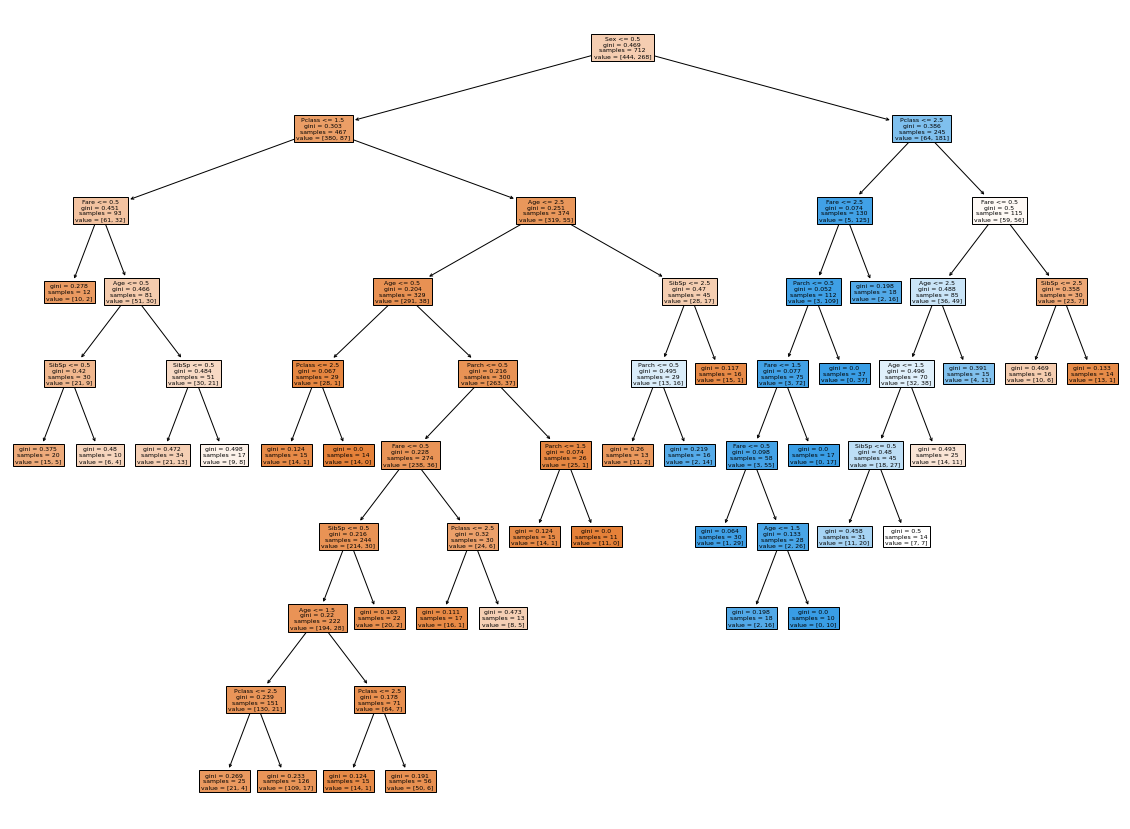

Unfortunately this tree is too deep and wide to interpret here, let's try less features


In [35]:
from sklearn import tree

clf_titanic = DecisionTreeClassifier(splitter='best', 
                                     min_samples_split=11, 
                                     min_samples_leaf=10,
                                     criterion='gini',
                                     random_state=42)

clf_titanic.fit(X_train, y_train)
plt.figure(figsize=(20,15))
tree.plot_tree(clf_titanic, filled=True, feature_names=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'])
plt.show()
print("Unfortunately this tree is too deep and wide to interpret here, let's try less features")

In [36]:
# let's try two features with less score but still more than 0.65 to plot a tree

clf_titanic.fit(X_train[['Sex', 'Pclass']], y_train)
clf_titanic.score(X_test[['Sex', 'Pclass']], y_test)

0.7653631284916201

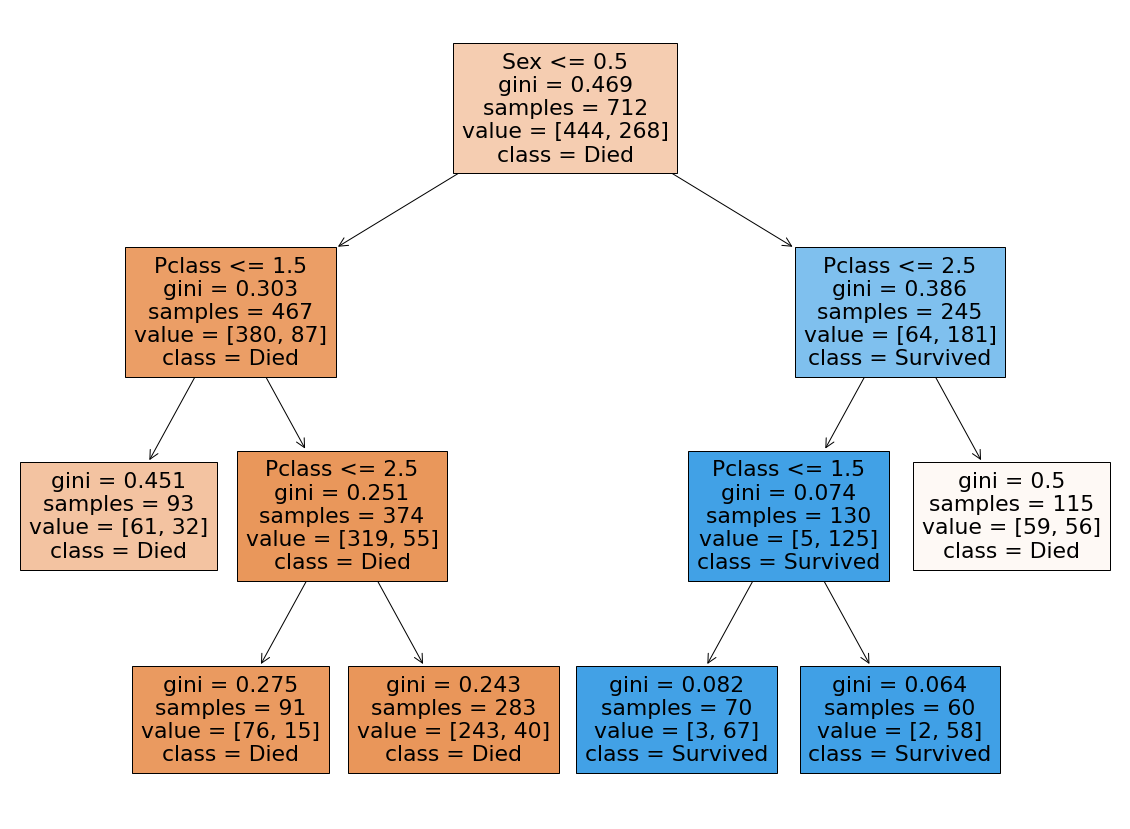

In [37]:
plt.figure(figsize=(20,15))
tree.plot_tree(clf_titanic, filled=True, feature_names=['Sex', 'Pclass'], class_names=['Died', 'Survived'])
plt.show()

Is it easy to interpret its results? Are you able to explain to a random person why would he survive / die on the titanic?

The last tree is pretty readable for a random person - this representation is almost self explanatory: a root node of the tree checks whether you're woman or a man and other levels estimate your class. So we can clearly see here that to have a better chance to survive Titanic disaster you need to be a woman with 1st class ticket.

# Homework part 2. RandomForestRegressor

**Task 7 (2 points)**. Write your own *DecisionTreeRegressor* class with _MSE_ split criterion and settable parameter *max_depth*. Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). <br>

Provide examples for different _max_depth_ parameter.

Of course you may re-use code for *DecisionTreeClassifier*. You need to figure out what needs to be changed in it for Classification -> Regression transformation.<br>

**! You are allowed to use only NumPy library** in this assigment.

In [38]:
import numpy as np

def f(X):
    return X[:, 0]**3 + np.log(np.exp(X[:, 1]) + np.exp(X[:, 2])) + np.sqrt(abs(X[:, 3])) * X[:, 4]

n_samples = 100

stdv = 1. / np.sqrt(5)

X = np.random.uniform(-stdv, stdv, size = (n_samples, 5))
y = f(X)

In [39]:
def mse(y):
    return np.mean((y - np.mean(y)) ** 2)

def mse_loss(parent_node, splits):
    splits_mse = np.sum([mse(split)*(len(split)/len(parent_node)) for split in splits])
    return splits_mse

class MyDecisionTreeRegressor(object):
    
    def __init__(self, criterion=None, max_depth=None, random_state=None):
        self.impurity = None
        self.threshold = None
        self.column_index = None
        self.outcome_probs = None
        self.criterion = criterion
        self.max_depth = max_depth
        self.random_state=random_state
        self.left_child = None
        self.right_child = None
        
    def __repr__(self):
        return 'MyDecisionTreeRegressor'
        

    @property
    def is_terminal(self):         
        return not bool(self.left_child or self.right_child)

    def _find_splits(self, X):
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):

        # Sample random subset of features
        np.random.RandomState(self.random_state)
        subset = random.sample(list(range(0, X.shape[1])), n_features)
        min_loss, min_col, min_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                loss = self.criterion(y, splits)

                if (min_loss is None) or (loss < min_loss):
                    min_col, min_val, min_loss = column, value, loss
        return min_col, min_val, min_loss

    def fit(self, X, y, n_features=None):
        
        try:
            # Exit from recursion using assert syntax
            if self.max_depth is not None:
                assert self.max_depth > 0
                self.max_depth -= 1

            if n_features is None:
                n_features = X.shape[1]

            column, value, loss = self._find_best_split(X, y, n_features)
            assert loss is not None

            self.column_index = column
            self.threshold = value
            self.impurity = loss

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

            # Grow left and right child
            self.left_child = MyDecisionTreeRegressor(self.criterion, self.max_depth, self.random_state)
            self.left_child.fit(
                left_X, left_target, n_features
            )

            self.right_child = MyDecisionTreeRegressor(self.criterion, self.max_depth, self.random_state)
            self.right_child.fit(
                right_X, right_target, n_features
            )
        except AssertionError:
            self.outcome_probs = np.mean(y)
        return self
            


    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome_probs

    def predict(self, X):
        """Make predictions.
        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        """  
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

In [40]:
# custom instances with different max_depth parameter

my_reg_1 = MyDecisionTreeRegressor(criterion=mse_loss, max_depth=4, random_state=42)
my_reg_1.fit(X, y)

my_reg_2 = MyDecisionTreeRegressor(criterion=mse_loss, max_depth=10, random_state=42)
my_reg_2.fit(X, y)

MyDecisionTreeRegressor

In [41]:
from sklearn.tree import DecisionTreeRegressor

# lib instances with different max_depth parameter

lib_reg_1 = DecisionTreeRegressor(max_depth=4, random_state=42)
lib_reg_1.fit(X, y)

lib_reg_2 = DecisionTreeRegressor(max_depth=10, random_state=42)
lib_reg_2.fit(X, y)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [42]:
from sklearn.metrics import mean_squared_error

my_reg_score_1 = mean_squared_error(y, my_reg_1.predict(X))
lib_reg_score_1 = mean_squared_error(y, lib_reg_1.predict(X))

my_reg_score_2 = mean_squared_error(y, my_reg_2.predict(X))
lib_reg_score_2 = mean_squared_error(y, lib_reg_2.predict(X))

print(f'MSE of custom tree regressor(max_depth=4)   :   {my_reg_score_1}')
print(f'MSE of sklearn tree regressor(max_depth=4)  :   {lib_reg_score_1}')
print('-' * 70)
print(f'MSE of custom tree regressor(max_depth=10)  :   {my_reg_score_2}')
print(f'MSE of sklearn tree regressor(max_depth=10) :   {lib_reg_score_2}')

assert my_reg_score_1 == lib_reg_score_1
assert my_reg_score_2 == lib_reg_score_2


MSE of custom tree regressor(max_depth=4)   :   0.0038445090604170328
MSE of sklearn tree regressor(max_depth=4)  :   0.0038445090604170328
----------------------------------------------------------------------
MSE of custom tree regressor(max_depth=10)  :   7.805924774345206e-07
MSE of sklearn tree regressor(max_depth=10) :   7.805924774345206e-07


**Task 8 (2 points)**. Write your own _RandomForestRegressor_ class with MSE split criterion and settable parameter _max_depth_.  Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with [sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).<br>

Provide examples for different max_depth parameter.<br>

**! You are allowed to use only NumPy library** in this assigment.

In [43]:
class MyRandomForestRegressor(object):

    def __init__(self, n_estimators=100, max_depth=None, n_features=None, criterion='mse_loss', random_state=None, bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        self.random_state=random_state
        
        if criterion == 'mse_loss':
            self.criterion = mse_loss
        else:
            raise ValueError(f"Unknown criterion '{criterion}'")
            
        self.trees = [MyDecisionTreeRegressor(criterion=self.criterion, max_depth=self.max_depth, random_state=self.random_state) for _ in range(n_estimators)]
    
    def __repr__(self):
        return 'MyRandomForestRegressor'
    
    
    def _init_data(self, X, y):
        
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        np.random.RandomState(self.random_state)
        return np.random.randint(size, size=size)
    
    def fit(self, X, y):
        
        if self.n_features is None:
            self.n_features = X.shape[1]
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            tree.fit(
                X,
                y,
                n_features=self.n_features
            )
        return self
            
    def predict(self, X):
         
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators
                predictions[i] = row_pred
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

In [44]:
# custom instances with different max_depth parameter

my_forest_1 = MyRandomForestRegressor(criterion='mse_loss', max_depth=3, random_state=42)
my_forest_1.fit(X, y)

my_forest_2 = MyRandomForestRegressor(criterion='mse_loss', max_depth=4, random_state=42)
my_forest_2.fit(X, y)

MyRandomForestRegressor

In [45]:
from sklearn.ensemble import RandomForestRegressor

# lib instances with different max_depth parameter

lib_forest_1 = RandomForestRegressor(max_depth=3, random_state=42)
lib_forest_1.fit(X, y)

lib_forest_2 = RandomForestRegressor(max_depth=4, random_state=42)
lib_forest_2.fit(X, y)

RandomForestRegressor(max_depth=4, random_state=42)

In [46]:
my_forest_score_1 = mean_squared_error(y, my_forest_1.predict(X))
lib_forest_score_1 = mean_squared_error(y, lib_forest_1.predict(X))

my_forest_score_2 = mean_squared_error(y, my_forest_2.predict(X))
lib_forest_score_2 = mean_squared_error(y, lib_forest_2.predict(X))

print(f'MSE of custom tree regressor(max_depth=3)  :   {my_forest_score_1}')
print(f'MSE of sklearn tree regressor(max_depth=3) :   {lib_forest_score_1}')
print('-' * 70)
print(f'MSE of custom tree regressor(max_depth=5)  :   {my_forest_score_2}')
print(f'MSE of sklearn tree regressor(max_depth=5) :   {lib_forest_score_2}')

MSE of custom tree regressor(max_depth=3)  :   0.005318152391213269
MSE of sklearn tree regressor(max_depth=3) :   0.004724096428509323
----------------------------------------------------------------------
MSE of custom tree regressor(max_depth=5)  :   0.0023521715580423755
MSE of sklearn tree regressor(max_depth=5) :   0.0024176542039003237


In case of custom RandomForestRegressor numbers of MSE compared to sklearn RandomForestRegressor are not exactly the same. I think it's because we haven't take all default parameters into consideration. So it can't be that precise.

# Homework part 3 (bonus). Speeding up forest training process

**Task 9 (3 points)** Devise a way to speed up training against the default version of our custom _RandomForestClassifier_ or your own _RandomForestRegressor_. You may want use [`joblib`](https://joblib.readthedocs.io/en/latest/) for parallelizing trees training. Provide graphs of time dependences on the number of trees in your _fast_ version with different number of cores / threads used against default one.

In [47]:
from joblib import Parallel, delayed

class MyRandomForestRegressor(object):

    def __init__(self, n_estimators=10, n_jobs=None, max_depth=None, n_features=None, criterion="mse_loss", random_state=None, bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        self.random_state=random_state
        self.n_jobs=n_jobs
        
        if criterion == 'mse_loss':
            self.criterion = mse_loss
        else:
            raise ValueError(f"Unknown criterion '{criterion}'")
            
        self.trees = [MyDecisionTreeRegressor(criterion=self.criterion) for _ in range(n_estimators)]
        
    def __repr__(self):
        return 'MyRandomForestRegressor'
        
    def _init_data(self, X, y):

        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        np.random.seed(self.random_state)
        return np.random.randint(size, size=size)
    
    def _check_bootstrap(self):
        if self.bootstrap:
            idxs = self.bootstrap_data(self.size)
            X = self.X[idxs]
            y = self.y[idxs]
            return X, y
        else:
            X = self.X
            y = self.y
            return X, y
    
    def fit(self, X, y):
                
        if self.n_features is None:
            self.n_features = int(np.sqrt(X.shape[1]))
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        self.results = Parallel(n_jobs=self.n_jobs)(delayed(tree.fit)(*self._check_bootstrap(), n_features=self.n_features) for tree in self.trees)
        
        return self
    
    def predict(self, X):
                  
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0
                for tree in self.results:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators
                predictions[i] = row_pred
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

In [49]:
from time import time

# defining the number of trees to measure computational time

estimators = np.linspace(10, 100, 9, dtype=int)

# single process(default)
times_1 = []
for i in estimators:
    my_reg_boost = MyRandomForestRegressor(n_estimators=i, n_jobs=1, criterion='mse_loss', random_state=42)
    start = time()
    my_reg_boost.fit(X, y)
    end = time()
    times_1.append(end - start)

# two parallel processes
times_2 = []
for i in estimators:
    my_reg_boost = MyRandomForestRegressor(n_estimators=i, n_jobs=2, criterion='mse_loss', random_state=42)
    start = time()
    my_reg_boost.fit(X, y)
    end = time()
    times_2.append(end - start)
    
# three parallel processes
times_3 = []
for i in estimators:
    my_reg_boost = MyRandomForestRegressor(n_estimators=i, n_jobs=3, criterion='mse_loss', random_state=42)
    start = time()
    my_reg_boost.fit(X, y)
    end = time()
    times_3.append(end - start)
    
# four parallel processes    
times_4 = []
for i in estimators:
    my_reg_boost = MyRandomForestRegressor(n_estimators=i, n_jobs=4, criterion='mse_loss', random_state=42)
    start = time()
    my_reg_boost.fit(X, y)
    end = time()
    times_4.append(end - start)

# sklearn regressor with single process
times_5 = []
for i in estimators:
    reg_boost = RandomForestRegressor(n_estimators=i, random_state=42)
    start = time()
    reg_boost.fit(X, y)
    end = time()
    times_5.append(end - start)


# sklearn regressor with four parallel processes 
times_6 = []
for i in estimators:
    reg_boost = RandomForestRegressor(n_estimators=i, n_jobs=4, random_state=42)
    start = time()
    reg_boost.fit(X, y)
    end = time()
    times_6.append(end - start)
    

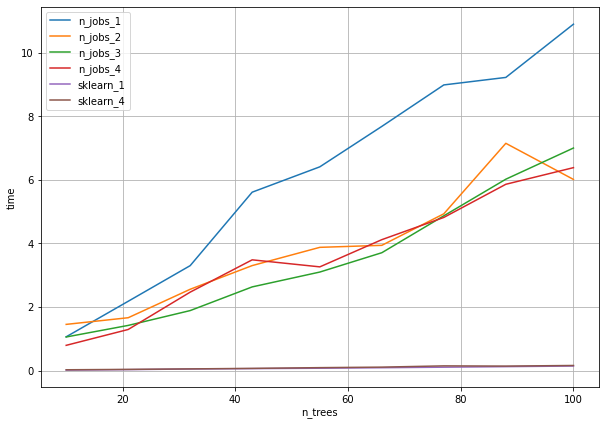

In [50]:
# results
fig, axes = plt.subplots(figsize=(10,7))
plt.plot(estimators, times_1, label='n_jobs_1')
plt.plot(estimators, times_2, label='n_jobs_2')
plt.plot(estimators, times_3, label='n_jobs_3')
plt.plot(estimators, times_4, label='n_jobs_4')
plt.plot(estimators, times_5, label='sklearn_1')
plt.plot(estimators, times_6, label='sklearn_4')

plt.grid()
plt.xlabel('n_trees')
plt.ylabel('time')
plt.legend()
plt.show()